# Time Series Forecasting Model Evaluation

### Common Imports

In [1]:
from sklearn.model_selection import train_test_split

from helpers import *
from abstract import ForecastingMethod
import numpy as np

# Linear Regression

In [2]:
from linear_regression import LinearRegression

Training Loss (MSE): 0.6464337680951172
Testing Loss (MSE): 1.4651054264204697
Model parameters: {'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'positive': False}


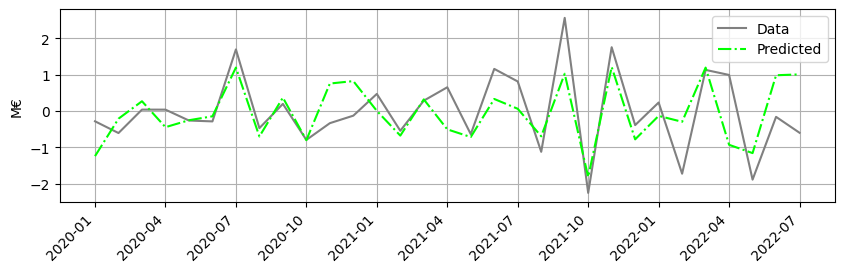

Training Loss (MSE): 0.6640157130285588
Testing Loss (MSE): 1.653296846753885
Model parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


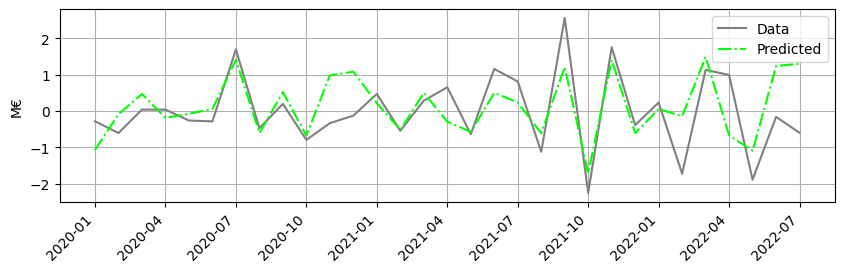

Training Loss (MSE): 0.9063167349657723
Testing Loss (MSE): 1.2823975309758666
Model parameters: {'alpha': 0.5, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


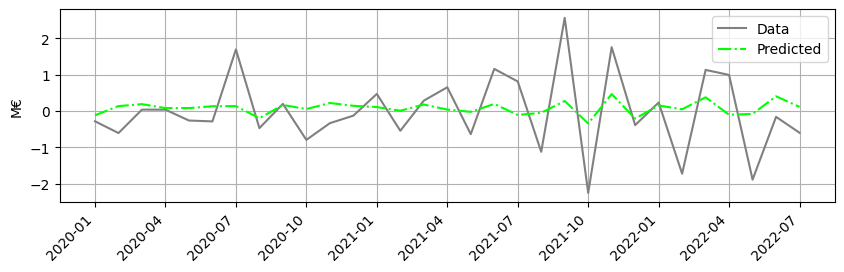

Training Loss (MSE): 0.9703123028298489
Testing Loss (MSE): 1.3863815500308458
Model parameters: {'alpha': 200, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001}


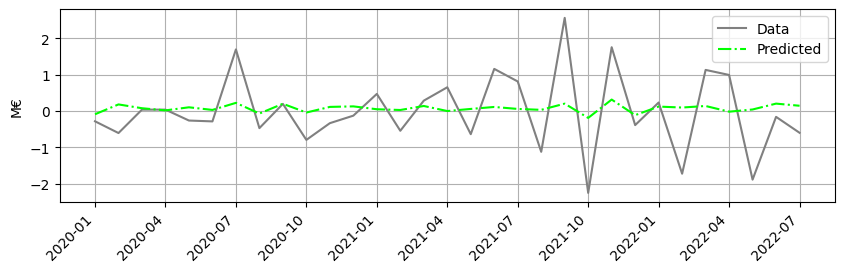

In [3]:
X, y = ForecastingMethod.load_data("../data/paper-data.csv")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

models = [
    LinearRegression(regularization=None, fit_intercept=False, cv_folds=None),
    LinearRegression(regularization=None, fit_intercept=True, cv_folds=None),
    LinearRegression(
        regularization="l1",
        fit_intercept=True,
        cv_folds=5,
        alphas=[0.1, 0.3, 0.5, 1, 5, 10, 100],
    ),
    LinearRegression(
        regularization="l2",
        fit_intercept=True,
        cv_folds=5,
        alphas=[0.1, 0.5, 1, 5, 10, 100, 200, 500, 1000],
    ),
]
for model in models:
    model.train(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Training Loss (MSE): {model.score(X, y)}")
    print(f"Testing Loss (MSE): {model.score(X_test, y_test)}")
    print(f"Model parameters: {model.model.get_params()}")

    plot_sales_growth(
        date(2020, 1, 1),
        y,
        model.predict(X),
        pred_linestyle="-.",
        pred_color="lime",
    )

# PQC

In [4]:
from pqc import PQC_Forecast

### Training - Data Preparation

In [5]:
TRAIN_TEST_RATIO = 8 / 10

# Preprocess the data: Apply normalization and scaling like paper
new_filepath, min_value, max_value, initial_value = (
    PQC_Forecast.preprocess_data(
        filepath="../data/paper-data.csv",
        difference=False,
        scale_to_range=True,
        training_data_cutoff=TRAIN_TEST_RATIO,
    )
)

# Load the data
X, y = PQC_Forecast.load_data(filepath=new_filepath)

# Split the data into training and testing sets
train_test_split_index = int(len(X) * TRAIN_TEST_RATIO)
train_X, train_y, test_X, test_y = (
    X[:train_test_split_index],
    y[:train_test_split_index],
    X[train_test_split_index:],
    y[train_test_split_index:],
)

### Training - Model Creation and Weight Finding

In [6]:
N_WIRES = 12
N_LAYERS = 2

# Create LBFGS-B model
pqc_model_lbfgsb = PQC_Forecast(
    n_wires=N_WIRES, n_layers=N_LAYERS, optimizer="L-BFGS-B"
)
# Create the COBYLA model
pqc_model_cobyla = PQC_Forecast(
    n_wires=N_WIRES, n_layers=N_LAYERS, optimizer="COBYLA"
)

# load weights - since training takes 30+ minutes
pqc_model_lbfgsb.load_weights("../weights/pqc_weights_lbfgsb.npy")
pqc_model_cobyla.load_weights("../weights/pqc_weights_cobyla.npy")

True

### Prediction - Timeseries Forcasting + Results

In [7]:
# Predict the dataset as whole
predictions_L = pqc_model_lbfgsb.predict(X)
predictions_C = pqc_model_cobyla.predict(X)

# Compute the Training MSE with processed data
mse_L = np.mean((predictions_L[:train_test_split_index] - train_y) ** 2)
mse_C = np.mean((predictions_C[:train_test_split_index] - train_y) ** 2)
print(f"Training MSE L-BFGS-B: {mse_L}")
print(f"Training MSE COBYLA: {mse_C}")
# Compute Testing MSE
mse_L = np.mean((predictions_L[train_test_split_index:] - test_y) ** 2)
mse_C = np.mean((predictions_C[train_test_split_index:] - test_y) ** 2)
print(f"Testing MSE L-BFGS-B: {mse_L}")
print(f"Testing MSE COBYLA: {mse_C}")

Training MSE L-BFGS-B: 0.004288775586416771
Training MSE COBYLA: 0.005599549793777868
Testing MSE L-BFGS-B: 0.011969983879400011
Testing MSE COBYLA: 0.009690624175123605


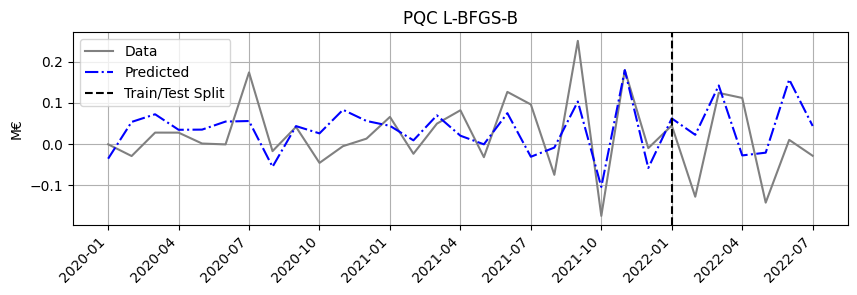

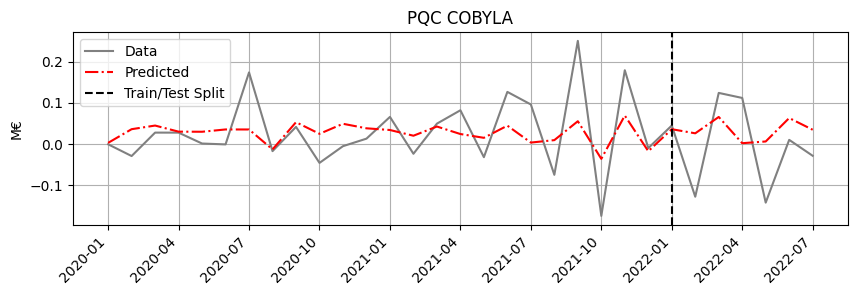

In [8]:
# Post process the predictions
predictions_L = PQC_Forecast.post_process_data(
    predictions_L, min_value, max_value, initial_value
)
predictions_C = PQC_Forecast.post_process_data(
    predictions_C, min_value, max_value, initial_value
)
# Post process y
y = PQC_Forecast.post_process_data(y, min_value, max_value, initial_value)

# Plot the results
plot_sales_growth(
    date(2020, 1, 1),
    y,
    predictions_L,
    pred_linestyle="-.",
    pred_color="blue",
    title="PQC L-BFGS-B",
    train_test_split=train_test_split_index,
)
plot_sales_growth(
    date(2020, 1, 1),
    y,
    predictions_C,
    pred_linestyle="-.",
    pred_color="red",
    title="PQC COBYLA",
    train_test_split=train_test_split_index,
)